In [2]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.6/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [3]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F212N']
filters = ['m_jwst_F162M', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [4]:
# read nbody data
path_to_data = '../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma1p0/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.6)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

        mass        isMultiple ...       log_a               age        
------------------- ---------- ... ------------------ ------------------
0.11411525852041825        0.0 ...                nan 1.5856250135269634
  12.96283688892593        0.0 ...                nan 1.5815614514229481
 39.427654349524886        0.0 ...                nan 1.5815614514229481
0.27321673034539384        0.0 ...                nan 1.5809681130539752
0.23029620900072592        0.0 ...                nan  1.599940093822274
 0.3058690028542314        0.0 ...                nan  1.599940093822274
 14.494145017213652        0.0 ...                nan 1.5901414103153855
0.07746465814392134        0.0 ...                nan  1.594747251459704
 0.3033320386270977        0.0 ...                nan 1.5944003377230693
0.23707198644689903        0.0 ...                nan 1.5944003377230693
                ...        ... ...                ...                ...
0.04231069763318475        1.0 ...  2.9131336956144

In [5]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[6.17609126 6.30103   ]
[1500000. 2000000.]


In [6]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


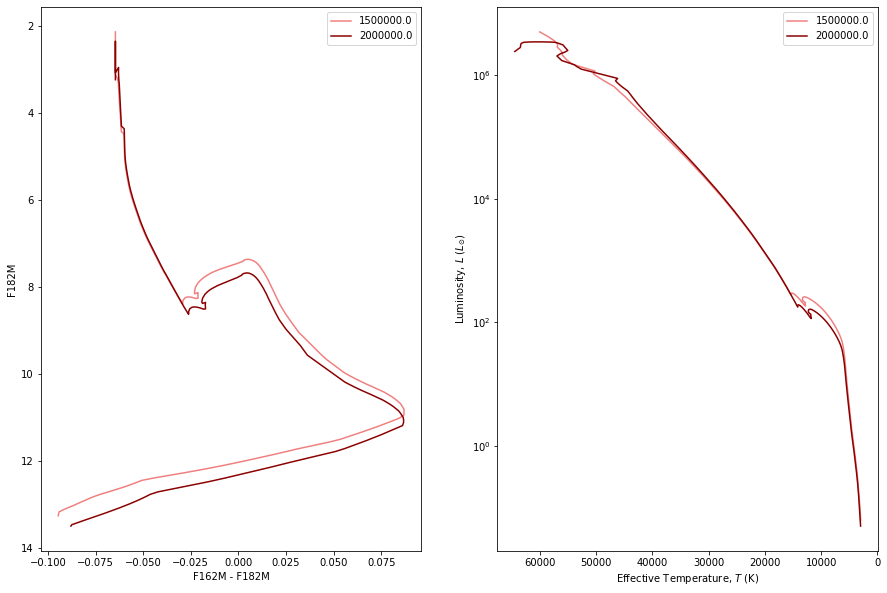

In [7]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 2:
    idx_arr = idx_arr[::2]

'''
label_arr = np.empty(len(idx_arr))
for i in range(len(idx_arr)):
    label_arr[i] = (idx_arr[i] / 2) + 1
    
color_arr = ["lightcoral", "indianred", "firebrick", "maroon", "darkred"]
'''
   
# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F162M - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

# Plot HR
py.subplot(1, 2, 2)
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    data_iso_Lsun = instances[idx].points['L'] * watts_to_lsun
    if i == 0:
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'darkred', label=level_age_arr[i])
    else:    
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'red', label='')
    
py.yscale('log')
py.xlabel('Effective Temperature, $T$ (K)')
py.ylabel('Luminosity, $L$ ($L_{\odot}$)')
py.gca().invert_xaxis()

py.legend()

In [8]:
import interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)

# convert luminosity values to solar luminosities
for i in range(len(stars)):
    stars[i][0] = stars[i][0] * watts_to_lsun

# print(stars)

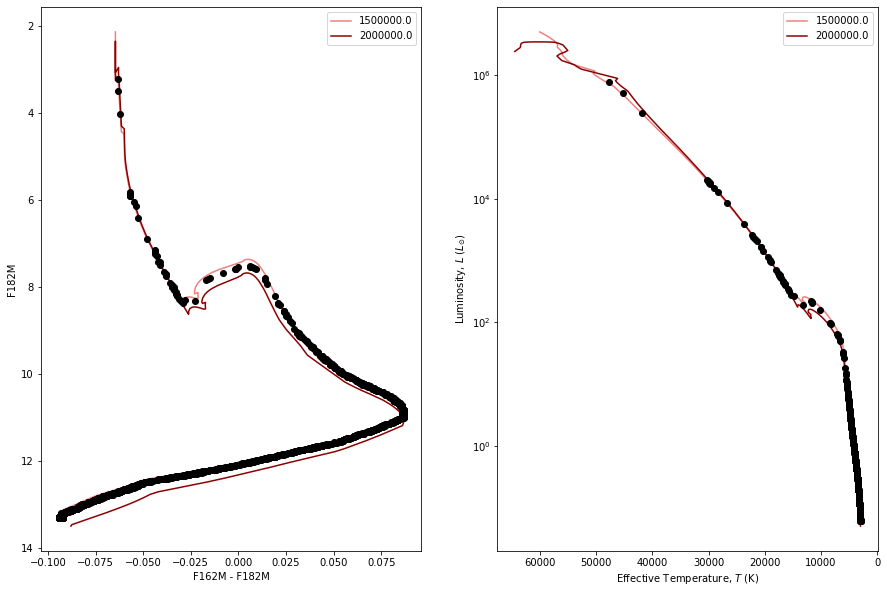

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)

for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F162M - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', color='k')
    
py.xlabel('F162M - F182M')
py.ylabel('F182M')

# Plot HR
py.subplot(1, 2, 2)

for i in range(len(idx_arr)):
    idx = idx_arr[i]
    data_iso_Lsun = instances[idx].points['L'] * watts_to_lsun
    if i == 0:
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'darkred', label=level_age_arr[i])
    else:    
        py.plot(instances[idx].points['Teff'], data_iso_Lsun, 'red', label='')
    
py.yscale('log')
py.xlabel('Effective Temperature, $T$ (K)')
py.ylabel('Luminosity, $L$ ($L_{\odot}$)')
py.gca().invert_xaxis()

for i in range(len(stars)):
    py.plot(stars[i][1], stars[i][0], marker='o', color='k')

py.legend()